# Correlation Between Gene Degree and Predicted Disease Association

The bulk of this notebook comes from https://github.com/AstraZeneca/biomedical-kg-topological-imbalance/tree/master
But it has been changed to instead use a biological network of my own construction. Here with 4 phenotype terms: premature_thelarche, decreased_serum_estradiol, seizure, global_developmental_delay it is show how the rotatE score is extremely well correlated with the degree of the gene predicted to be connected to the phenotype.


In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from pykeen.datasets.hetionet import Hetionet
from scipy import stats
import sys
import os
from pykeen.datasets.base import PathDataset
from pykeen.predict import predict_target
from scipy.stats import kstest
import pickle

sys.path.append(os.path.abspath('../src/'))

from utils import get_predictions_tail

sns.set_theme(style="whitegrid", palette="muted", font_scale=1.5, rc={"axes.grid": False})

/Users/michael/miniconda3/envs/link/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Loading

Here we load a small network made by combinding STRING PPI and the Human Phenotype Ontology (HPO).

In [2]:
TEST_PATH: str =  '../ELs_for_Rotate/String_HPO_2019.all_hpo/test.txt'
TRAIN_PATH: str = '../ELs_for_Rotate/String_HPO_2019.all_hpo/train.txt'
VALID_PATH: str = '../ELs_for_Rotate/String_HPO_2019.all_hpo/valid.txt'

class STRINGHPO(PathDataset):
    def __init__(self, **kwargs):
        super().__init__(
            training_path=TRAIN_PATH,
            testing_path=TEST_PATH,
            validation_path=VALID_PATH,
            **kwargs,
        )

data = STRINGHPO()
data.summarize() 

# these are used to know if a triple is in the training, testing or validation set
train_triples = set([ str(x) for x in data.training.triples])
test_triples = set([ str(x) for x in data.testing.triples])
valid_triples = set([ str(x) for x in data.validation.triples])

You're trying to map triples with 537 entities and 0 relations that are not in the training set. These triples will be excluded from the mapping.
In total 535 from 30992 triples were filtered out
Reconstructing all label-based triples. This is expensive and rarely needed.


STRINGHPO (create_inverse_triples=False)
Name        Entities    Relations      Triples
----------  ----------  -----------  ---------
Training    36245       3              6029790
Testing     36245       3                30457
Validation  36245       3               135927
Total       -           -              6196174
Head        Relation    tail
----------  ----------  ----------
HP:0000001  HPO2HPO     HP:0000005
HP:0000001  HPO2HPO     HP:0000118
HP:0000001  HPO2HPO     HP:0012823
HP:0000001  HPO2HPO     HP:0031797
HP:0000001  HPO2HPO     HP:0032223



Reconstructing all label-based triples. This is expensive and rarely needed.
Reconstructing all label-based triples. This is expensive and rarely needed.


In [3]:
# Load the STRING_HPO network edges
df: pd.DataFrame = pd.read_csv(
    "../ELs_for_Rotate/String_HPO_2019.all_hpo/train.txt", sep="\t"
)
df.columns = ["source", "relation", "target"]

# Load these edges into a NX graph and compute the degree for each entity
G: nx.MultiGraph = nx.from_pandas_edgelist(
    df, "source", "target", create_using=nx.MultiGraph()
)
degs: dict = dict(G.degree())

## Model Loading

Here a pretrained model is loaded back into pytorch ready for use in inference. If using a different weight file, please change the path below.

In [4]:
# Load the pretrained model
model = torch.load(
    "../PyKeenOut/stringhpo_rotate_trail_1.2/trained_model.pkl",
    map_location=torch.device("cpu"),
)

## Plotting Correlation Between Degree and Disease Association

We now use the pretrained model to make predictions and assess the correlation between gene degree and the score assigned by the model for association between gene and phenotype. 

In [5]:
premature_thelarche: str = 'HP:0010314'
decreased_serum_estradiol: str = 'HP:0008214'
seizure: str = 'HP:0001250'
global_developmental_delay = 'HP:0001263'

query_relation: str = "STRING2HPO"

We can now query the model by asking it to rank every entity in the graph by how likely it considers each entity to be to correct choice to complete the partial triple phenotype->associates->? The function below returns a dataframe of predictions for this partial triple sorted by assigned score.

In [6]:
seizure_df = get_predictions_tail(seizure,
                     query_relation,
                     data=data,
                     model=model,
                     degs=degs,
                     train_triples=train_triples,
                     test_triples=test_triples,
                     valid_triples=valid_triples)

print(seizure_df.head())

# predictions_df.head()

       tail_id     score  in_training  in_testing            tail_label  \
35545    35545 -0.746411        False       False             STRING:of   
34683    34683 -0.763700        False       False  STRING:developmental   
35980    35980 -0.954334        False       False        STRING:stature   
31316    31316 -1.000795        False       False           STRING:TBCE   
35787    35787 -1.016306        False       False      STRING:recessive   

      entity_type triple_type   deg  
35545      STRING       novel  2435  
34683      STRING       novel  1299  
35980      STRING       novel  1047  
31316      STRING       novel   630  
35787      STRING       novel  2592  


In [7]:
def plot_score_degree_all(df: pd.DataFrame, disease: str) -> None:
    
    # remove grey grid from sns
    sns.set_style("whitegrid", {"axes.grid": False})

    plt.figure(figsize=(12, 8))
    ax = sns.scatterplot(
        data=df,
        x="deg",
        y="score",
        hue="entity_type",
        style="entity_type",
        alpha=0.5,
        linewidth=0,
        size=1
    )
    ax.set(
        xscale="log",
        xlabel="Degree (log)",
        ylabel="Predicted Score",
        title=f"Degree Vs. Score for all Entities: {disease}",
    )
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), title="Entity Type")
    plt.show()

### All Entity Types

As every entity is scored in the prediction phase for the partial triple, we can now plot how the model scores these versus the degree of each entity. The plot below shows this, where each entity has been coloured by its type within the graph. We can see that the model scores all gene entities well above others, which makes sense as only genes are seen complete the DaG triples.

In [8]:
# plot_score_degree_all(premature_thelarche_df, "premature thelarche")

In [9]:
def plot_score_degree_gene(df: pd.DataFrame, disease: str) -> None:
    def annotate(data, **kws):

        _, _, r_value, _, _ = stats.linregress(np.log10(df["deg"]), df["score"])
        ax = plt.gca()
        ax.text(0.05, 0.8, f"$R^2$: {r_value**2:.2f}", transform=ax.transAxes)

    # remove grey grid from sns
    sns.set_style("whitegrid", {"axes.grid": False})

    ax = sns.lmplot(
        data=df,
        x="deg",
        y="score",
        hue="triple_type",
        hue_order=["novel", "train", "test"],
        logx=True,
        n_boot=10000,
        seed=0,
        height=6,
        aspect=1.2,
        scatter_kws={"alpha": 0.5, "s": 1},
    )
    ax.map_dataframe(annotate)
    ax.set(
        xscale="log",
        xlabel="Degree (log)",
        ylabel="Predicted Score",
        xlim=(0.5, 11000),
        title=f"Degree Vs. Score for Genes: {disease}",
    )
    ax.legend.set_title("Triple Type")
    ax.legend.set_bbox_to_anchor((0.95, 0.5))
    plt.show()

### Gene Degree versus Predicted Score: [Seizure](https://hpo.jax.org/app/browse/term/HP:0001250)

We can now filter the larger dataframe for just the gene entities and plot the correlation between entity degree and score again for the phenotype Seizure. 

This shows there to be a clear correlation between degree and score - the higher the degree, the more likely the model considers the gene to be associated to the disease.

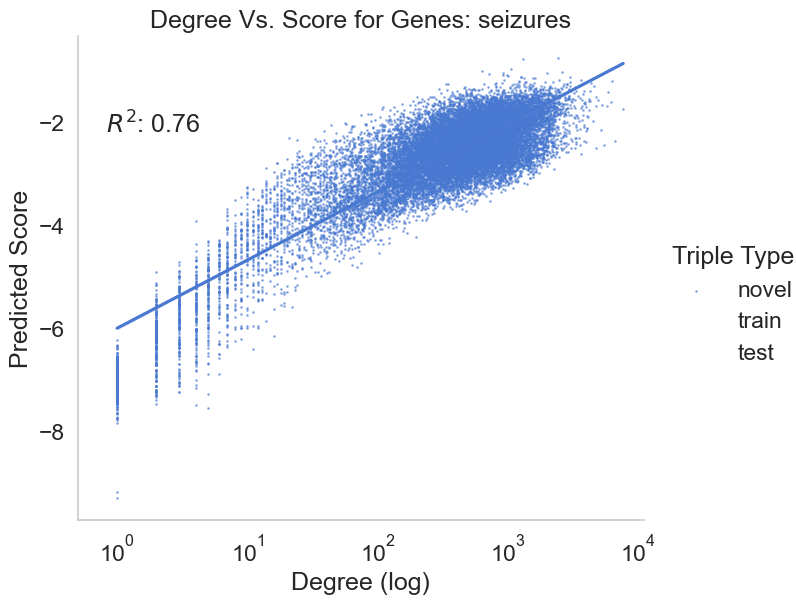

In [10]:
predictions_df_genes: pd.DataFrame = seizure_df[seizure_df.entity_type == "STRING"]
plot_score_degree_gene(predictions_df_genes, "seizures")

### Gene Degree versus Predicted Score: [Premature thelarche](https://hpo.jax.org/app/browse/term/HP:0010314)

This relationship holds no matter the phenotype in questions: here we investigate Premature thelarche


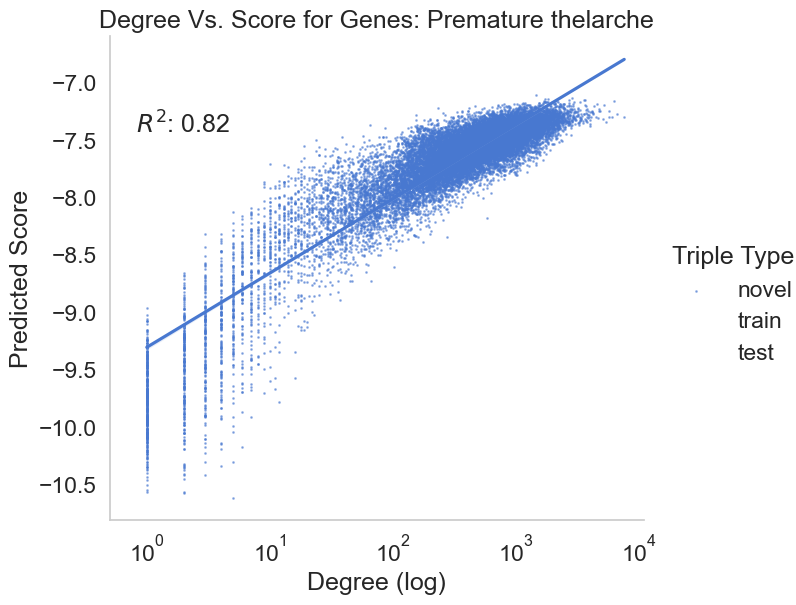

In [11]:
predictions_df: pd.DataFrame = get_predictions_tail(
    premature_thelarche,
    query_relation,
    data,
    model,
    degs,
    train_triples=train_triples,
    test_triples=test_triples,
    valid_triples=valid_triples
)
predictions_df = predictions_df[predictions_df.entity_type == "STRING"]
plot_score_degree_gene(predictions_df, "Premature thelarche")

### Gene Degree versus Predicted Score: [Decreased serum estradiol](https://hpo.jax.org/app/browse/term/HP:0008214)

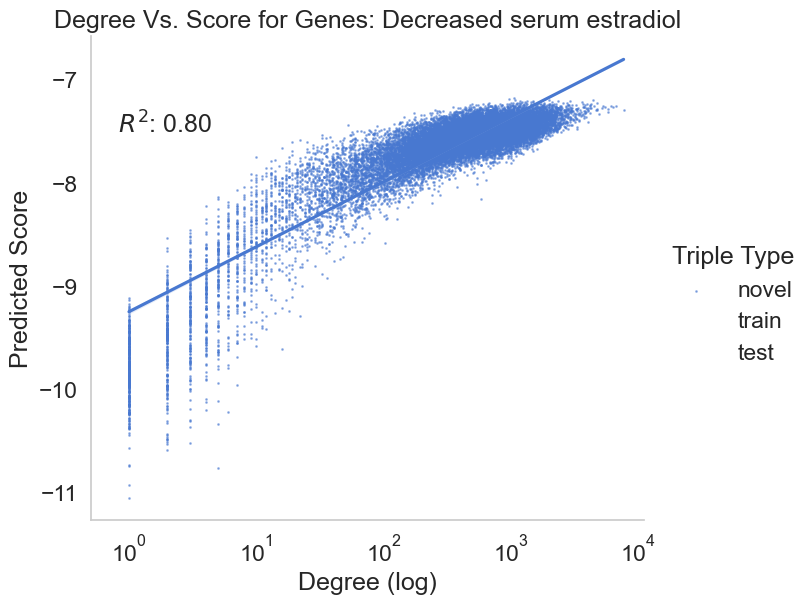

In [12]:
predictions_df: pd.DataFrame = get_predictions_tail(
    decreased_serum_estradiol,
    query_relation,
    data,
    model,
    degs,
    train_triples=train_triples,
    test_triples=test_triples,
    valid_triples=valid_triples
)
predictions_df = predictions_df[predictions_df.entity_type == "STRING"]
plot_score_degree_gene(predictions_df, "Decreased serum estradiol")

### Gene Degree versus Predicted Score: [Global developmental delay](https://hpo.jax.org/app/browse/term/HP:0001263)

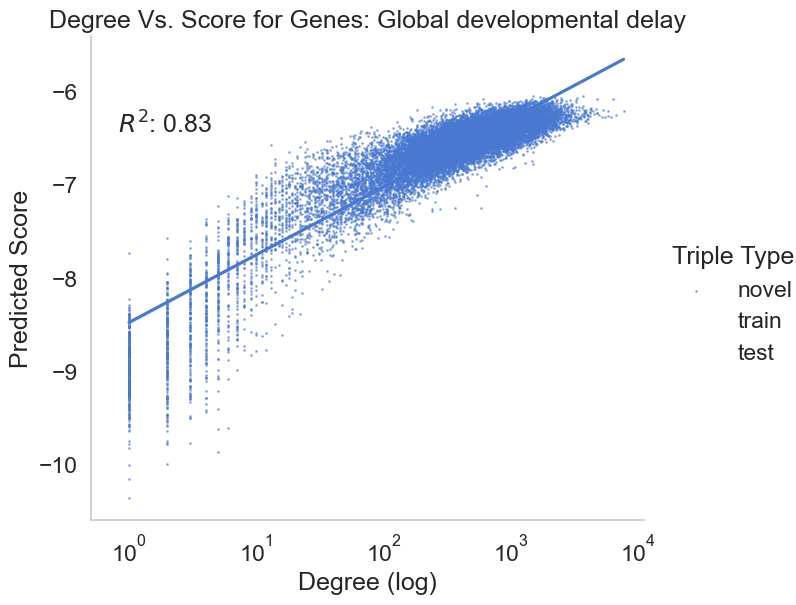

In [13]:
predictions_df: pd.DataFrame = get_predictions_tail(
    global_developmental_delay,
    query_relation,
    data,
    model,
    degs,
    train_triples=train_triples,
    test_triples=test_triples,
    valid_triples=valid_triples
)
predictions_df = predictions_df[predictions_df.entity_type == "STRING"]
plot_score_degree_gene(predictions_df, "Global developmental delay")

What if we flip this prediction on it's head? What is the score of an HPO term being associated with a gene?
What is the score for a gene being connected to an HPO term it is known to be related to vs all HPO terms?

## Will the known causal genes for an ultra rare disease be highly rank phenotypes is it known to cause?
###  Multicentric carpo-tarsal osteolysis with or without nephropathy (MCTO) [ORPHA:2774](https://hpo.jax.org/app/browse/disease/ORPHA:2774)

This is very rare syndrome characterized by progressive loss of bones in the hands and feet. There is a clearly known genetic cause from mutations to the gene MAFB. [Sophie's Neighborhood](https://www.sophiesneighborhood.org/) served as the inspiration for this test case.

Since we are dealing with phenotypes and MCTO is a disease, we will search for 10 HPO terms that are "very frequently" (as stated on the HPO website) with MCTO
HPO terms:
* HP:0004326  Cachexia
* HP:0000325  Triangular face
* HP:0000347  Micrognathia
* HP:0000520  Proptosis
* HP:0000093  Proteinuria
* HP:0001376  Limitation of joint mobility
* HP:0002797  Osteolysis
* HP:0003457  EMG abnormality
* HP:0001225  Wrist swelling
* HP:0001495  Carpal osteolysis
* HP:0001504  Metacarpal osteolysis
* HP:0003019  Abnormality of the wrist
* HP:0001288  Gait disturbance

Result: except for a few terms that seem more general (HP:0000325  Triangular face), (HP:0001225  Wrist swelling) the terms make it into > 90th percentile

In [14]:
mcto_hpos: list =  ['HP:0004326', 'HP:0000325', 'HP:0000347', 'HP:0000520', 'HP:0000093', 'HP:0001376', 'HP:0002797', 'HP:0003457', 'HP:0001225', 'HP:0001495', 'HP:0001504', 'HP:0003019', 'HP:0001288']
predictions_df: pd.DataFrame = get_predictions_tail(
    'STRING:MAFB',
    query_relation,
    data,
    model,
    degs,
    train_triples=train_triples,
    test_triples=test_triples,
    valid_triples=valid_triples
)
predictions_df = predictions_df[predictions_df.entity_type == "HP"]
print(predictions_df.head())
predictions_df['percentile'] = predictions_df['score'].rank(pct=True)
# for each hpo get the score and the percile of the score
for hpo in mcto_hpos:
    row = predictions_df[predictions_df['tail_label'] == hpo]
    print(hpo,float(row['score']), float(row['percentile']))
    # what is the index of the score in the sorted list

    


      tail_id     score  in_training  in_testing  tail_label entity_type  \
936       936 -1.909015        False       False  HP:0001217          HP   
527       527 -2.001811        False       False  HP:0000677          HP   
8619     8619 -2.004519        False       False  HP:0012165          HP   
576       576 -2.150958        False       False  HP:0000738          HP   
2670     2670 -2.156372        False       False  HP:0003745          HP   

     triple_type  deg  
936        novel   31  
527        novel   42  
8619       novel   22  
576        novel  114  
2670       novel   95  
HP:0004326 -2.553602933883667 0.9908131084601672
HP:0000325 -7.164275169372559 0.27286439051144934
HP:0000347 -2.5230674743652344 0.9922528451940217
HP:0000520 -2.490621328353882 0.9932812285753462
HP:0000093 -2.2715530395507812 0.9982174688057041
HP:0001376 -5.316133499145508 0.9184834773070067
HP:0002797 -2.3687987327575684 0.9963663787193199
HP:0003457 -5.560956001281738 0.8983957219251337
HP:

/var/folders/ty/694s8g7n1cz_l5s3prx55jzr0000gn/T/ipykernel_997/4108666289.py:18: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(hpo,float(row['score']), float(row['percentile']))


## Sex-specific terms
What is the average percentile for a sex-specific term being related to ALL genes?

In [15]:
# this cell originally took 425 minutes to run - results have been pickled in the following cell
# load sex specific data
female_hpos: list = [ line.strip() for line in open('../Resources/just_female_hpos.txt')]
print('# female terms', len(female_hpos))
male_hpos: list = [ line.strip() for line in open('../Resources/just_male_hpos.txt')]
print('# male terms', len(male_hpos))

# get a set of genes
genes = set()
for line in open(TRAIN_PATH,'r'):
    row = line.strip().split('\t')
    if 'STRING:' in row[0]:
        genes.add(row[0])
    if 'STRING:' in row[2]:
        genes.add(row[2])
print('# genes', len(genes))

def update_hpo_percentiles(hp_dict: dict,df: pd.DataFrame, hpos: list) -> dict: 
    for h in hpos:
        if h not in hp_dict:
            hp_dict[h] = []
        row = df.loc[df['tail_label'] == h,'percentile']
        if row.size == 0:
            continue
        p = row.values[0]
        hp_dict[h].append(p)
    return hp_dict

female_hpo_percentiles = {}
male_hpo_percentiles = {}
for i,gene in enumerate(genes):
    if i % 1000 == 0:
        print(round(i/len(genes),2) * 100, '% done')
    try:
        predictions_df: pd.DataFrame = get_predictions_tail(
            gene,
            query_relation,
            data,
            model,
            degs,
            train_triples=train_triples,
            test_triples=test_triples,
            valid_triples=valid_triples
        )
    except KeyError:
        print('key error', gene)
        continue
    predictions_df['percentile'] = predictions_df['score'].rank(pct=True)
    female_hpo_percentiles = update_hpo_percentiles(female_hpo_percentiles, predictions_df, female_hpos)
    male_hpo_percentiles = update_hpo_percentiles(male_hpo_percentiles, predictions_df, male_hpos)
    

# female terms 87
# male terms 169
# genes 21659
0.0 % done
5.0 % done
9.0 % done
14.000000000000002 % done


KeyboardInterrupt: 

In [ ]:


# pickle female_hpo_percentiles and male_hpo_percentiles
pickle.dump(female_hpo_percentiles,open('female_hpo_percentiles.pkl','wb'))
pickle.dump(male_hpo_percentiles,open('male_hpo_percentiles.pkl','wb'))

In [17]:
# pickle load
female_hpo_percentiles = pickle.load(open('female_hpo_percentiles.pkl','rb'))
male_hpo_percentiles = pickle.load(open('male_hpo_percentiles.pkl','rb'))

### Check to make sure all of the HPO terms have the same number of gene measurements
One female HPO term, HP:0033085 has 0 because it was not added untill 2020 and this was trained on 2019. I think we can safely ignore this one for now.

Similarly for the men there are 5 missing
* HP:0033195 - added in 2020
* HP:0033425 - added 2021
* HP:0033606 - added 2021
* HP:0033725 - added 2021
* HP:0034049 - added 2022

While small in number it is kind of ironic that there are still 5 times as many terms added since 2019 that are used to only describe men compared to the number describing women.

In [ ]:
# check that all hpos have the same number of genes
hpos_to_skip: set = set()

first_len: int = None
for key in female_hpo_percentiles.keys():
    if first_len is None:
        first_len = len(female_hpo_percentiles[key])
    else:
        
        if first_len == len(female_hpo_percentiles[key]):
            pass
        else:
            print('warning female',key, first_len, len(female_hpo_percentiles[key]))
            hpos_to_skip.add(key)

first_len: int = None
for key in male_hpo_percentiles.keys():
    if first_len is None:
        first_len = len(male_hpo_percentiles[key])
    else:
        
        if first_len == len(male_hpo_percentiles[key]):
            pass
        else:
            print('warning male', key, first_len, len(male_hpo_percentiles[key]))
            hpos_to_skip.add(key)

# remove hpos from both dicts that are in hpos_to_skip
for hpo in hpos_to_skip:
    if hpo in male_hpo_percentiles:
        male_hpo_percentiles.pop(hpo)
    if hpo in female_hpo_percentiles:
        female_hpo_percentiles.pop(hpo)

warning female HP:0033085 21659 0
warning male HP:0033195 21659 0
warning male HP:0033725 21659 0
warning male HP:0034049 21659 0
warning male HP:0033606 21659 0
warning male HP:0033425 21659 0


Create a dataframe with stats about the score percentiles for each HPO term across all genes

In [ ]:
# create stats for each hpo, mean, median, std
stats: dict = {'hpo': [], 'sex':[], 'mean': [], 'median': [], 'std': []}

for key in female_hpo_percentiles.keys():
    mn = np.mean(female_hpo_percentiles[key])
    md = np.median(female_hpo_percentiles[key])
    std = np.std(female_hpo_percentiles[key])
    stats['hpo'].append(key)
    stats['sex'].append('female')
    stats['mean'].append(mn)
    stats['median'].append(md)
    stats['std'].append(std)

for key in male_hpo_percentiles.keys():
    mn = np.mean(male_hpo_percentiles[key])
    md = np.median(male_hpo_percentiles[key])
    std = np.std(male_hpo_percentiles[key])
    stats['hpo'].append(key)
    stats['sex'].append('male')
    stats['mean'].append(mn)
    stats['median'].append(md)
    stats['std'].append(std)

stats_df = pd.DataFrame(stats)
stats_df['deg'] = stats_df['hpo'].apply(lambda x: degs[x])


print(stats_df.head())
print(stats_df.shape)

          hpo     sex      mean    median       std  deg
0  HP:0010314  female  0.313982  0.317120  0.135494    1
1  HP:0008214  female  0.256035  0.234957  0.146393    1
2  HP:0008038  female  0.699757  0.759360  0.128002    3
3  HP:0000204  female  0.781436  0.810429  0.084796    6
4  HP:0032565  female  0.848397  0.877004  0.085307    1
(250, 6)


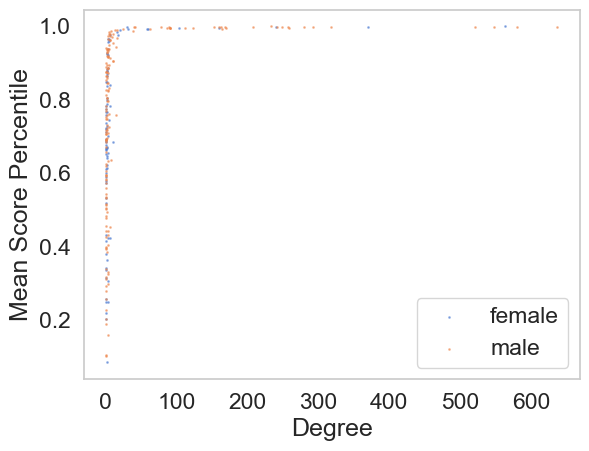

In [ ]:
for sex in ['female','male']:
    sub = stats_df[stats_df['sex'] == sex]
    plt.scatter(sub['deg'],sub['mean'],label=sex,s=1,alpha=0.5)

plt.xlabel('Degree')
plt.ylabel('Mean Score Percentile')
plt.legend()
plt.show()

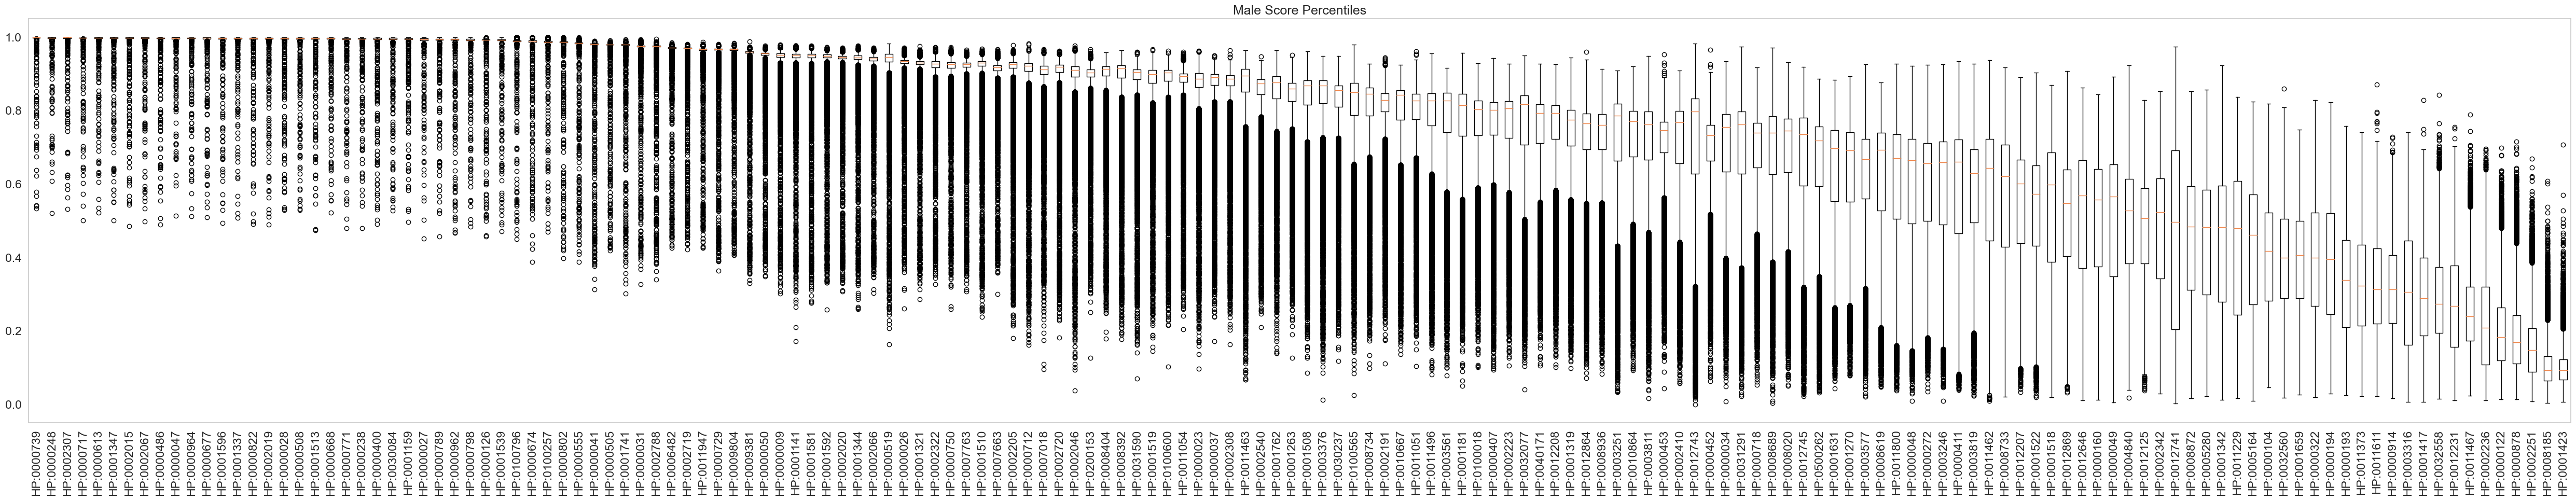

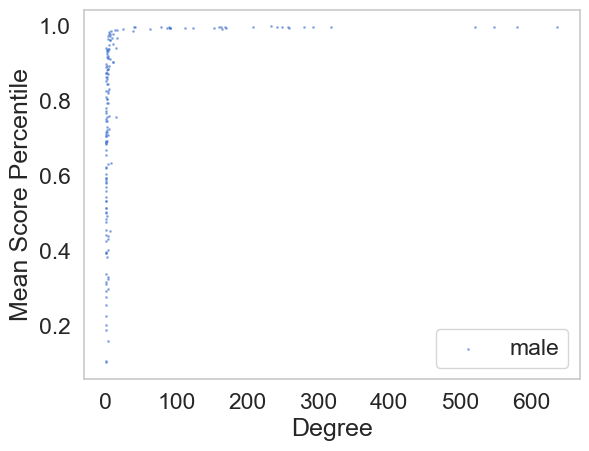

In [21]:

sex = 'male'
sub = stats_df[stats_df['sex'] == sex]
# sort sub my mean
sub = sub.sort_values(by=['mean'],ascending=False)
sorted_male_dict = {}
for hpo in sub['hpo']:
    sorted_male_dict[hpo] = male_hpo_percentiles[hpo]

# # make a box plot of each hpo term's scores
fig, ax = plt.subplots(figsize=(50, 10))
ax.boxplot(sorted_male_dict.values())
ax.set_xticklabels(sorted_male_dict.keys(), rotation=90)
plt.title('Male Score Percentiles')
plt.tight_layout()
plt.show()
plt.clf()

plt.scatter(sub['deg'],sub['mean'],label=sex,s=1,alpha=0.5)
plt.xlabel('Degree')
plt.ylabel('Mean Score Percentile')
plt.legend()
plt.show()


          hpo     sex      mean    median       std  deg
0  HP:0010314  female  0.313982  0.317120  0.135494    1
1  HP:0008214  female  0.256035  0.234957  0.146393    1
2  HP:0008038  female  0.699757  0.759360  0.128002    3
3  HP:0000204  female  0.781436  0.810429  0.084796    6
4  HP:0032565  female  0.848397  0.877004  0.085307    1


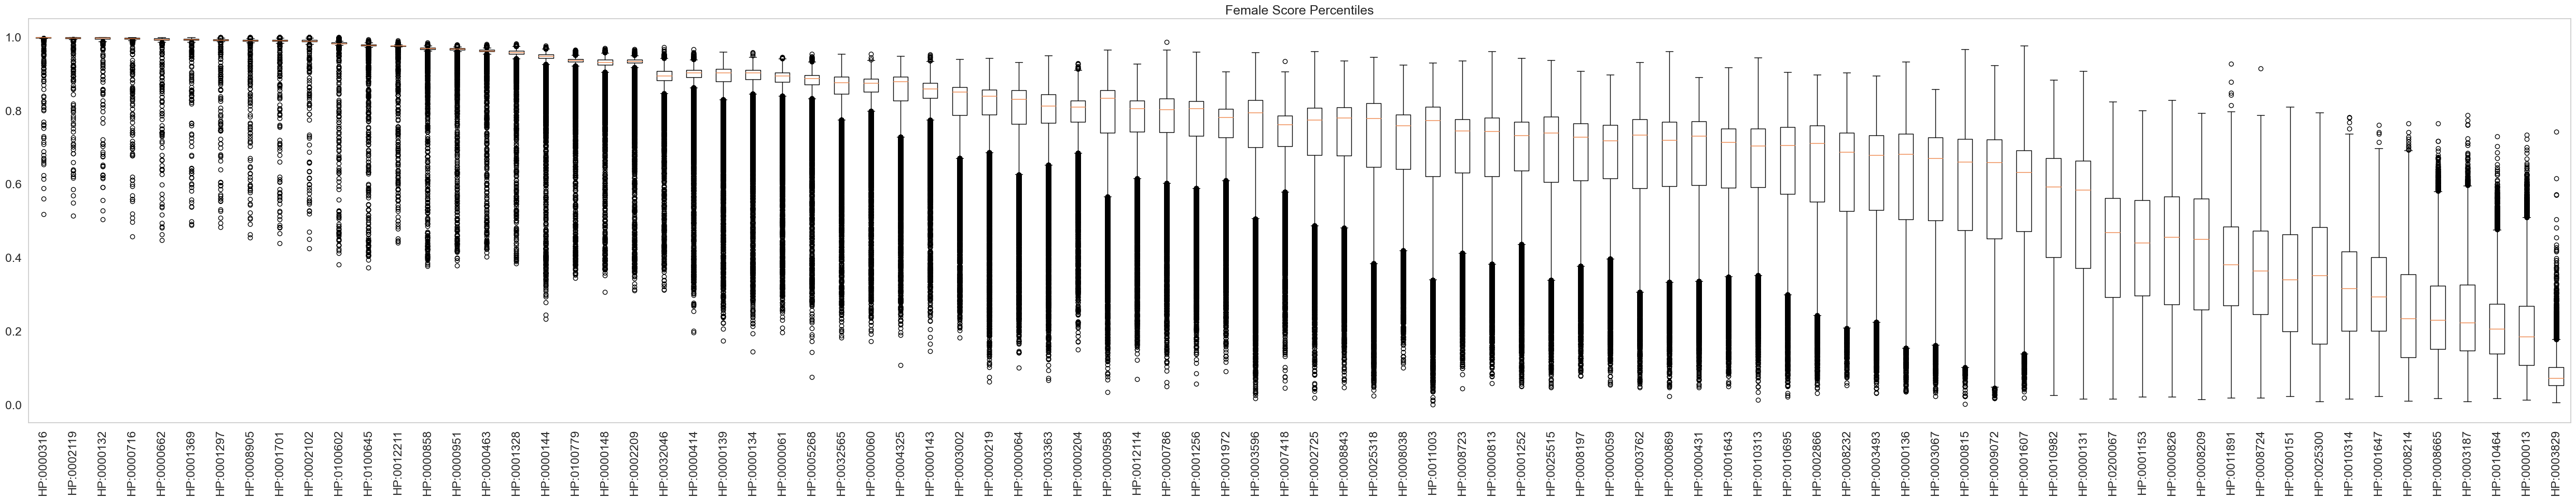

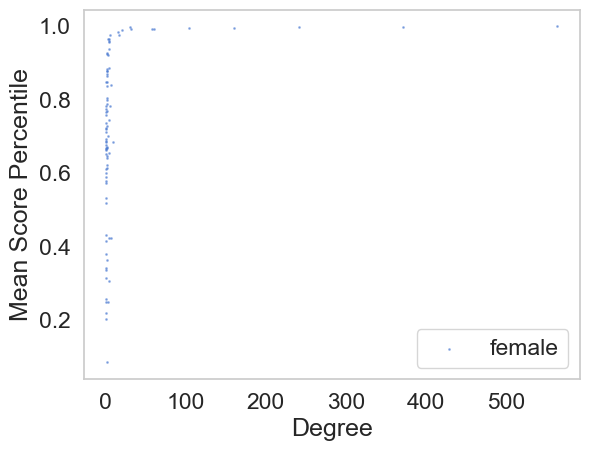

In [22]:
sex = 'female'
sub = stats_df[stats_df['sex'] == sex]
print(sub.head())
# sort sub my mean
sub = sub.sort_values(by=['mean'],ascending=False)
sorted_dict = {}
for hpo in sub['hpo']:
    sorted_dict[hpo] = female_hpo_percentiles[hpo]

# # make a box plot of each hpo term's scores
fig, ax = plt.subplots(figsize=(50, 10))
ax.boxplot(sorted_dict.values())
ax.set_xticklabels(sorted_dict.keys(), rotation=90)
plt.title('Female Score Percentiles')
plt.tight_layout()
plt.show()
plt.clf()

plt.scatter(sub['deg'],sub['mean'],label=sex,s=1,alpha=0.5)
plt.xlabel('Degree')
plt.ylabel('Mean Score Percentile')
plt.legend()
plt.show()

### Is there a statistical difference between the distributions of mean percentiles in females vs males

There is some evidence (p=0.064, KS test) that there is a difference between the two, where males have a much higher proportion of mean score percentiles > .9 (39% vs 24%)

KstestResult(statistic=0.17101531480431084, pvalue=0.063651310893602, statistic_location=0.8825385787102998, statistic_sign=1)


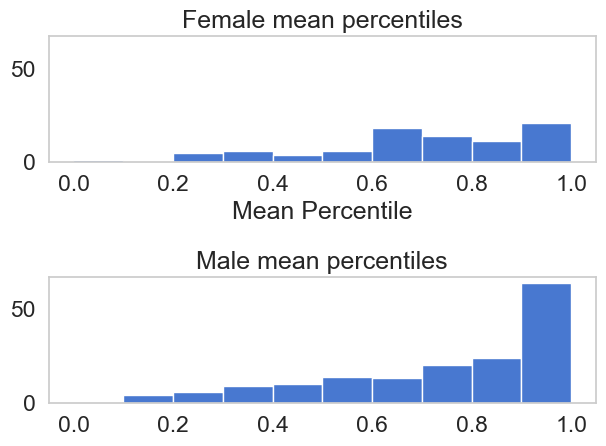

% of hpo with mean percentile score > 90%
Female 0.2441860465116279
Male 0.3902439024390244


In [23]:

print(kstest(stats_df[stats_df['sex'] == 'female']['mean'],
       stats_df[stats_df['sex'] == 'male']['mean']))

fix, axes = plt.subplots(2,sharey=True, tight_layout=True)
axes[0].hist(stats_df[stats_df['sex'] == 'female']['mean'],bins=10,range=(0,1))
axes[1].hist(stats_df[stats_df['sex'] == 'male']['mean'],bins=10,range=(0,1))
axes[0].set_title('Female mean percentiles')
axes[1].set_title('Male mean percentiles')
axes[0].set_xlabel('Mean Percentile')

plt.show()

# get the % of hpos that with mean > .9
def get_percent_above(df: pd.DataFrame, percentile: float) -> float:
    return len(df[df['mean'] > percentile])/df.shape[0]

print('% of hpo with mean percentile score > 90%')
print('Female', get_percent_above(stats_df[stats_df['sex'] == 'female'],.9))
print('Male', get_percent_above(stats_df[stats_df['sex'] == 'male'],.9))


## Manually Curated Female/Male Terms from all of HPO

In [24]:
female_terms = []
male_terms = []
for line in open('../SexCurationResults/file_1686685843.3780549.csv','r'):
    row = line.strip().split(',')
    if row[2] == 'm':
        male_terms.append(row[1])
    elif row[2] == 'f':
        female_terms.append(row[1])
    elif row[2] == 'o':
        pass
    else: 
        print('error', row)

print('Number of female terms:',len(female_terms))
print('Number of male terms:',len(male_terms))

error ['', 'hpo', 'label']
error ['0', 'hpo', 'label']
Number of female terms: 288
Number of male terms: 192


In [25]:
all_female_hpo_percentiles = {}
all_male_hpo_percentiles = {}
for i,gene in enumerate(genes):
    if i % 1000 == 0:
        print(round(i/len(genes),2) * 100, '% done')
    try:
        predictions_df: pd.DataFrame = get_predictions_tail(
            gene,
            query_relation,
            data,
            model,
            degs,
            train_triples=train_triples,
            test_triples=test_triples,
            valid_triples=valid_triples
        )
    except KeyError:
        print('key error', gene)
        continue
    predictions_df['percentile'] = predictions_df['score'].rank(pct=True)
    all_female_hpo_percentiles = update_hpo_percentiles(all_female_hpo_percentiles, predictions_df, female_terms)
    all_male_hpo_percentiles = update_hpo_percentiles(all_male_hpo_percentiles, predictions_df, male_terms)

0.0 % done


KeyboardInterrupt: 

In [ ]:
print(len(all_female_hpo_percentiles))
pickle.dump(all_female_hpo_percentiles,open('all_female_hpo_percentiles.pkl','wb'))
pickle.dump(all_male_hpo_percentiles,open('all_male_hpo_percentiles.pkl','wb'))

In [26]:
all_female_hpo_percentiles = pickle.load(open('all_female_hpo_percentiles.pkl','rb'))
all_male_hpo_percentiles = pickle.load(open('all_male_hpo_percentiles.pkl','rb'))

print(len(all_female_hpo_percentiles))
print(len(all_male_hpo_percentiles))

288
192


In [27]:
# remove HPO nots in the G

skipped_female_hpos = []
for key in list(all_female_hpo_percentiles.keys()):
    if key not in G.nodes():
        # remove key from dict
        all_female_hpo_percentiles.pop(key)
        skipped_female_hpos.append(key)

skipped_male_hpos = []
for key in list(all_male_hpo_percentiles.keys()):
    if key not in G.nodes():
        # remove key from dict
        all_male_hpo_percentiles.pop(key)
        skipped_male_hpos.append(key)

print(len(all_female_hpo_percentiles))
print(len(all_male_hpo_percentiles))

# create stats for each hpo, mean, median, std
all_stats: dict = {'hpo': [], 'sex':[], 'mean': [], 'median': [], 'std': []}

for key in all_female_hpo_percentiles.keys():
    mn = np.mean(all_female_hpo_percentiles[key])
    md = np.median(all_female_hpo_percentiles[key])
    std = np.std(all_female_hpo_percentiles[key])
    all_stats['hpo'].append(key)
    all_stats['sex'].append('female')
    all_stats['mean'].append(mn)
    all_stats['median'].append(md)
    all_stats['std'].append(std)

for key in all_male_hpo_percentiles.keys():
    mn = np.mean(all_male_hpo_percentiles[key])
    md = np.median(all_male_hpo_percentiles[key])
    std = np.std(all_male_hpo_percentiles[key])
    all_stats['hpo'].append(key)
    all_stats['sex'].append('male')
    all_stats['mean'].append(mn)
    all_stats['median'].append(md)
    all_stats['std'].append(std)

all_stats_df = pd.DataFrame(all_stats)
all_stats_df['deg'] = all_stats_df['hpo'].apply(lambda x: degs[x])


print(all_stats_df.head())
print(all_stats_df.shape)

251
169
          hpo     sex      mean    median       std  deg
0  HP:0030161  female  0.910456  0.927742  0.062491    2
1  HP:0000142  female  0.961581  0.965733  0.035390   19
2  HP:0000008  female  0.956983  0.960850  0.032803    7
3  HP:0010460  female  0.935083  0.945730  0.049492    3
4  HP:0030425  female  0.487741  0.557511  0.197387    1
(420, 6)


KstestResult(statistic=0.09168061481883119, pvalue=0.33709800579402943, statistic_location=0.9458891113975952, statistic_sign=1)


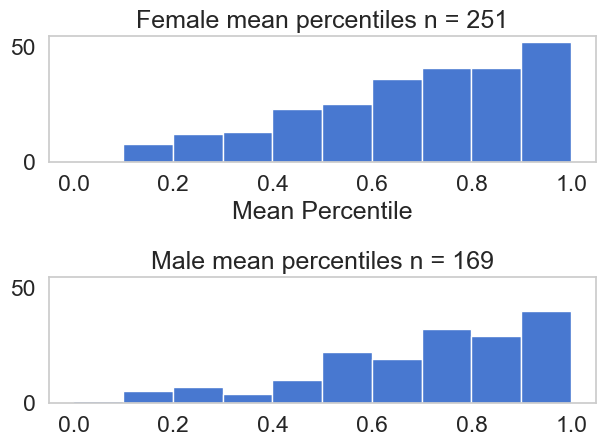

% of hpo with mean percentile score > 90%
Female 0.20717131474103587
Male 0.23668639053254437


In [28]:

print(kstest(all_stats_df[all_stats_df['sex'] == 'female']['mean'],
       all_stats_df[all_stats_df['sex'] == 'male']['mean']))

fix, axes = plt.subplots(2,sharey=True, tight_layout=True)
axes[0].hist(all_stats_df[all_stats_df['sex'] == 'female']['mean'],bins=10,range=(0,1))
axes[1].hist(all_stats_df[all_stats_df['sex'] == 'male']['mean'],bins=10,range=(0,1))
axes[0].set_title('Female mean percentiles n = {}'.format(str(sum(all_stats_df['sex'] == 'female'))))
axes[1].set_title('Male mean percentiles n = {}'.format(str(sum(all_stats_df['sex'] == 'male'))))
axes[0].set_xlabel('Mean Percentile')

plt.show()

# get the % of hpos that with mean > .9
def get_percent_above(df: pd.DataFrame, percentile: float) -> float:
    return len(df[df['mean'] > percentile])/df.shape[0]

print('% of hpo with mean percentile score > 90%')
print('Female', get_percent_above(all_stats_df[all_stats_df['sex'] == 'female'],.9))
print('Male', get_percent_above(all_stats_df[all_stats_df['sex'] == 'male'],.9))

KstestResult(statistic=0.08538626558853345, pvalue=0.4227690550010002, statistic_location=0.7533176989929645, statistic_sign=1)


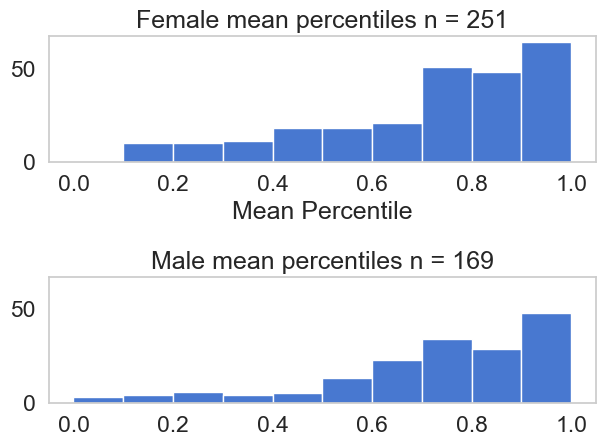

% of hpo with mean percentile score > 90%
Female 0.20717131474103587
Male 0.23668639053254437


In [29]:

print(kstest(all_stats_df[all_stats_df['sex'] == 'female']['median'],
       all_stats_df[all_stats_df['sex'] == 'male']['median']))

fix, axes = plt.subplots(2,sharey=True, tight_layout=True)
axes[0].hist(all_stats_df[all_stats_df['sex'] == 'female']['median'],bins=10,range=(0,1))
axes[1].hist(all_stats_df[all_stats_df['sex'] == 'male']['median'],bins=10,range=(0,1))
axes[0].set_title('Female mean percentiles n = {}'.format(str(sum(all_stats_df['sex'] == 'female'))))
axes[1].set_title('Male mean percentiles n = {}'.format(str(sum(all_stats_df['sex'] == 'male'))))
axes[0].set_xlabel('Mean Percentile')

plt.show()

# get the % of hpos that with mean > .9
def get_percent_above(df: pd.DataFrame, percentile: float) -> float:
    return len(df[df['mean'] > percentile])/df.shape[0]

print('% of hpo with mean percentile score > 90%')
print('Female', get_percent_above(all_stats_df[all_stats_df['sex'] == 'female'],.9))
print('Male', get_percent_above(all_stats_df[all_stats_df['sex'] == 'male'],.9))

## Sexually Differentially Expressed Genes

In [30]:
xls = pd.ExcelFile('../Resources/aba3066-table-s2.xlsx')

gene_tissue_counts_female = {}
gene_tissue_counts_male = {}
t2g2s = {'tissue':[],'gene':[],'sex':[]}
tissue_2_gene_by_sex = {}
for sheet_name in xls.sheet_names[2:]:
    xdf = xls.parse(sheet_name)
    for i,row in xdf.iterrows():
        g = row['HUGO_gene_id']
        is_female = row['MASH beta'] > 0
        if is_female:
            if g not in gene_tissue_counts_female:
                gene_tissue_counts_female[g] = 0
            gene_tissue_counts_female[g] += 1
            t2g2s['tissue'].append(sheet_name)
            t2g2s['gene'].append(g)
            t2g2s['sex'].append('female')
        else:
            if g not in gene_tissue_counts_male:
                gene_tissue_counts_male[g] = 0
            gene_tissue_counts_male[g] += 1
            t2g2s['tissue'].append(sheet_name)
            t2g2s['gene'].append(g)
            t2g2s['sex'].append('male')

# build a DF for these that are differentially expressed and with greater expression in females
genes_female = gene_tissue_counts_female.keys()
data_female = {'gene':genes_female,'tissue_count':[gene_tissue_counts_female[g] for g in genes_female]}
df_female = pd.DataFrame(data_female)
df_female['tissue_count'].max()
print('females',df_female[df_female['tissue_count'] == df_female['tissue_count'].max()])
df_female = df_female[df_female['tissue_count'] < 45]
print('females',df_female.shape)

# build a DF for these that are differentially expressed and with greater expression in males
genes_male = gene_tissue_counts_male.keys()
data_male = {'gene':genes_male,'tissue_count':[gene_tissue_counts_male[g] for g in genes_male]}
df_male = pd.DataFrame(data_male)
df_male['tissue_count'].max()
print('males',df_male[df_male['tissue_count'] == df_male['tissue_count'].max()])
df_male = df_male[df_male['tissue_count'] < 45]
print('males',df_male.shape)

females    gene  tissue_count
27  NaN           739
females (2433, 2)
males   gene  tissue_count
3  NaN          1090
males (2364, 2)


In [31]:
print(df_male.head())
print(df_female.head())

        gene  tissue_count
0     GREB1L            15
1      ZBED1            42
2       CD99            44
4       SGCZ             4
5  LINC00844            10
     gene  tissue_count
0    XIST            44
1   KDM6A            44
2   KDM5C            44
3  EIF1AX            44
4   RPS4X            44


2364
2433


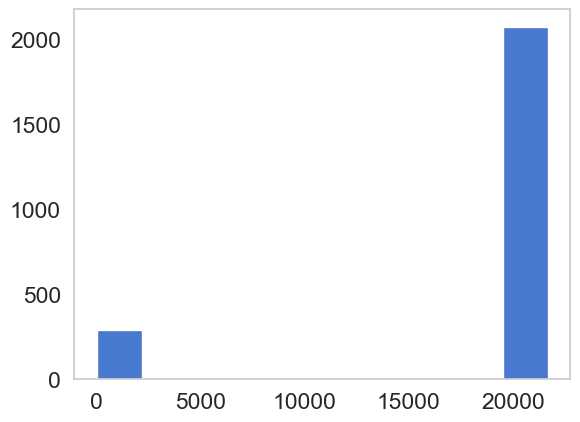

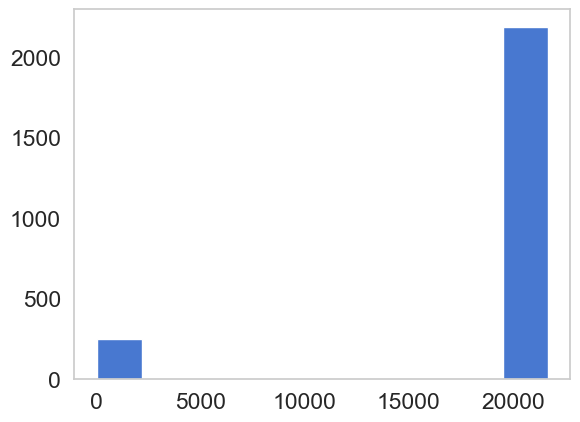

In [32]:

all_female_g2g_percentiles = None
all_male_g2g_percentiles = None
for f in os.listdir('../G2G_Shards/'):
    tmp = pickle.load(open('../G2G_Shards/{}'.format(f),'rb'))
    if 'female' in f:
        if all_female_g2g_percentiles is None:
            all_female_g2g_percentiles = tmp
            continue
        # update all_female_g2g_percentiles to include the new data
        for key in tmp.keys():
            all_female_g2g_percentiles[key] = all_female_g2g_percentiles[key] + tmp[key]
    else:
        if all_male_g2g_percentiles is None:
            all_male_g2g_percentiles = tmp
            continue
        for key in tmp.keys():
            all_male_g2g_percentiles[key] = all_male_g2g_percentiles[key] + tmp[key]

print(len(all_male_g2g_percentiles))
print(len(all_female_g2g_percentiles))

# plot a hist of the lens of each key in male and female
plt.hist([ len(all_male_g2g_percentiles[k]) for k in all_male_g2g_percentiles.keys()])
plt.show()

plt.hist([ len(all_female_g2g_percentiles[k]) for k in all_female_g2g_percentiles.keys()])
plt.show()


In [33]:
# get the scores for each gene being connected to an hpo xor a gene (seporate these two)
female_genes = list(df_female['gene'])
male_genes =  list(df_male['gene'])

query_relation: str = "STRING2STRING"

all_female_g2g_percentiles = {}
all_male_g2g_percentiles = {}
for i,gene in enumerate(genes):
    if i % 1000 == 0:
        print(round(i/len(genes),2) * 100, '% done')
    try:
        predictions_df: pd.DataFrame = get_predictions_tail(
            gene,
            query_relation,
            data,
            model,
            degs,
            train_triples=train_triples,
            test_triples=test_triples,
            valid_triples=valid_triples
        )
    except KeyError:
        print('key error', gene)
        continue
    predictions_df['percentile'] = predictions_df['score'].rank(pct=True)
    all_female_g2g_percentiles = update_hpo_percentiles(all_female_g2g_percentiles, predictions_df, female_genes)
    all_male_g2g_percentiles = update_hpo_percentiles(all_male_g2g_percentiles, predictions_df, male_genes)

0.0 % done


KeyboardInterrupt: 

In [ ]:
pickle.dump(all_female_g2g_percentiles,open('all_female_g2g_percentiles.pkl','wb'))
pickle.dump(all_male_g2g_percentiles,open('all_male_g2g_percentiles.pkl','wb'))

In [34]:
# pickle load
all_female_g2g_percentiles = pickle.load(open('all_female_g2g_percentiles.pkl','rb'))
all_male_g2g_percentiles = pickle.load(open('all_male_g2g_percentiles.pkl','rb'))

In [35]:
t2g2s_df = pd.DataFrame(t2g2s)
num_tissues_specific_per_gene = {'gene':[],'sex':[],'num_tissues':[]}

# group t2g2s_df by sex and gene then count the number of tissues there are in each group
tissue_counts_by_gene = t2g2s_df.groupby(['sex','gene']).aggregate('count').reset_index()
print(tissue_counts_by_gene.head())


      sex      gene  tissue
0  female      A1BG      17
1  female  A1BG-AS1      17
2  female      AAAS       1
3  female      AASS       1
4  female     ABCA3       1


In [36]:
# create stats for each hpo, mean, median, std
all_g2g_stats: dict = {'gene': [], 'sex':[], 'mean': [], 'median': [], 'std': [], 'tissue_count': []}

female_sub = tissue_counts_by_gene[tissue_counts_by_gene['sex'] == 'female']
male_sub = tissue_counts_by_gene[tissue_counts_by_gene['sex'] == 'male']
for key in all_female_g2g_percentiles.keys():
    stripped_key = key.split(':')[-1]
    mn = np.mean(all_female_g2g_percentiles[key])
    md = np.median(all_female_g2g_percentiles[key])
    std = np.std(all_female_g2g_percentiles[key])
    all_g2g_stats['gene'].append(key)
    all_g2g_stats['sex'].append('female')
    all_g2g_stats['mean'].append(mn)
    all_g2g_stats['median'].append(md)
    all_g2g_stats['std'].append(std)
    # get all rows from tissue_counts_by_gene where sex == female and gene == key
    subsub = female_sub[female_sub['gene'] == stripped_key]
    assert len(list(subsub['tissue'])) == 1
    all_g2g_stats['tissue_count'].append(list(subsub['tissue'])[0])

for key in all_male_g2g_percentiles.keys():
    stripped_key = key.split(':')[-1]
    mn = np.mean(all_male_g2g_percentiles[key])
    md = np.median(all_male_g2g_percentiles[key])
    std = np.std(all_male_g2g_percentiles[key])
    all_g2g_stats['gene'].append(key)
    all_g2g_stats['sex'].append('male')
    all_g2g_stats['mean'].append(mn)
    all_g2g_stats['median'].append(md)
    all_g2g_stats['std'].append(std)
    # get all rows from tissue_counts_by_gene where sex == female and gene == key
    subsub = male_sub[male_sub['gene'] == stripped_key]
    assert len(list(subsub['tissue'])) == 1
    all_g2g_stats['tissue_count'].append(list(subsub['tissue'])[0])

all_g2g_stats_df = pd.DataFrame(all_g2g_stats)
all_g2g_stats_df['deg'] = [ degs[x] if x in degs else -1 in degs for x in all_g2g_stats_df['gene']]

# remove any row that has median of nan
all_g2g_stats_df = all_g2g_stats_df[~np.isnan(all_g2g_stats_df['median'])]
    

/Users/michael/miniconda3/envs/link/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/michael/miniconda3/envs/link/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/michael/miniconda3/envs/link/lib/python3.11/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/michael/miniconda3/envs/link/lib/python3.11/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/michael/miniconda3/envs/link/lib/python3.11/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [37]:
for i,k,v in zip(range(len(degs.keys())),degs.keys(),degs.values()):
    if i < 20000:
        continue
    print(i,k,v)
    if i > 20010:
        break

20000 STRING:RPS6KA2 757
20001 STRING:TNFRSF10C 366
20002 STRING:ADAMTS12 414
20003 STRING:STMN4 1340
20004 STRING:RPL37A 1147
20005 STRING:LEKR1 815
20006 STRING:NEK3 325
20007 STRING:TENC1 1102
20008 STRING:HIST1H3I 1409
20009 STRING:MRC2 422
20010 STRING:TPR 1684
20011 STRING:CLEC3B 688


In [38]:

# get the % of hpos that with mean > .9
def get_percent_above(df: pd.DataFrame, percentile: float, upper:float) -> float:
    sub = df[df['mean'] >= percentile]
    sub = sub[sub['mean'] < upper]
    return sub.shape[0]/df.shape[0]

KstestResult(statistic=0.027732869320059028, pvalue=0.3763782609066744, statistic_location=0.6252310663539798, statistic_sign=-1)


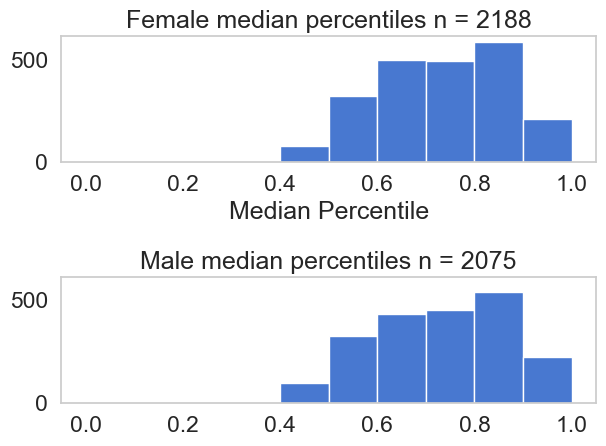

% of hpo with mean percentile score > 90%
Female 0.04661791590493602
Male 0.05012048192771084
% of hpo with mean percentile score between 80% and 90%
Female 0.31992687385740404
Male 0.30698795180722893
% of hpo with mean percentile score between 70% and 80%
Female 0.28244972577696525
Male 0.2833734939759036
% of hpo with mean percentile score between 60% and 70%
Female 0.23446069469835465
Male 0.2216867469879518
% of hpo with mean percentile score between 50% and 60%
Female 0.09917733089579525
Male 0.10891566265060242
% of hpo with mean percentile score between 40% and 50%
Female 0.016453382084095063
Male 0.02891566265060241
% of hpo with mean percentile score between 60% and 90%
Female 0.8368372943327239
Male 0.8120481927710843


In [39]:
# plot histograms of median divided by male and female

print(kstest(all_g2g_stats_df[all_g2g_stats_df['sex'] == 'female']['median'],
       all_g2g_stats_df[all_g2g_stats_df['sex'] == 'male']['median']))

fix, axes = plt.subplots(2,sharey=True, tight_layout=True)
axes[0].hist(all_g2g_stats_df[all_g2g_stats_df['sex'] == 'female']['median'],bins=10,range=(0,1))
axes[1].hist(all_g2g_stats_df[all_g2g_stats_df['sex'] == 'male']['median'],bins=10,range=(0,1))
axes[0].set_title('Female median percentiles n = {}'.format(str(sum(all_g2g_stats_df['sex'] == 'female'))))
axes[1].set_title('Male median percentiles n = {}'.format(str(sum(all_g2g_stats_df['sex'] == 'male'))))
axes[0].set_xlabel('Median Percentile')

plt.show()




print('% of hpo with mean percentile score > 90%')
print('Female', get_percent_above(all_g2g_stats_df[all_g2g_stats_df['sex'] == 'female'],0.9,1.00))
print('Male', get_percent_above(all_g2g_stats_df[all_g2g_stats_df['sex'] == 'male'],0.9,1.00))

# how many are in the 80-90% range
print('% of hpo with mean percentile score between 80% and 90%')
print('Female', get_percent_above(all_g2g_stats_df[all_g2g_stats_df['sex'] == 'female'],0.8,0.9))
print('Male', get_percent_above(all_g2g_stats_df[all_g2g_stats_df['sex'] == 'male'],0.8,0.9))

# how many are in the 70-80% range
print('% of hpo with mean percentile score between 70% and 80%')
print('Female', get_percent_above(all_g2g_stats_df[all_g2g_stats_df['sex'] == 'female'],0.7,0.8))
print('Male', get_percent_above(all_g2g_stats_df[all_g2g_stats_df['sex'] == 'male'],0.7,0.8))

print('% of hpo with mean percentile score between 60% and 70%')
print('Female', get_percent_above(all_g2g_stats_df[all_g2g_stats_df['sex'] == 'female'],0.6,0.7))
print('Male', get_percent_above(all_g2g_stats_df[all_g2g_stats_df['sex'] == 'male'],0.6,0.7))

print('% of hpo with mean percentile score between 50% and 60%')
print('Female', get_percent_above(all_g2g_stats_df[all_g2g_stats_df['sex'] == 'female'],0.5,0.6))
print('Male', get_percent_above(all_g2g_stats_df[all_g2g_stats_df['sex'] == 'male'],0.5,0.6))

print('% of hpo with mean percentile score between 40% and 50%')
print('Female', get_percent_above(all_g2g_stats_df[all_g2g_stats_df['sex'] == 'female'],0.4,0.5))
print('Male', get_percent_above(all_g2g_stats_df[all_g2g_stats_df['sex'] == 'male'],0.4,0.5))


print('% of hpo with mean percentile score between 60% and 90%')
print('Female', get_percent_above(all_g2g_stats_df[all_g2g_stats_df['sex'] == 'female'],0.6,0.9))
print('Male', get_percent_above(all_g2g_stats_df[all_g2g_stats_df['sex'] == 'male'],0.6,0.9))




Number of nan in deg 0
Number of nan in median 0
(4263, 7)


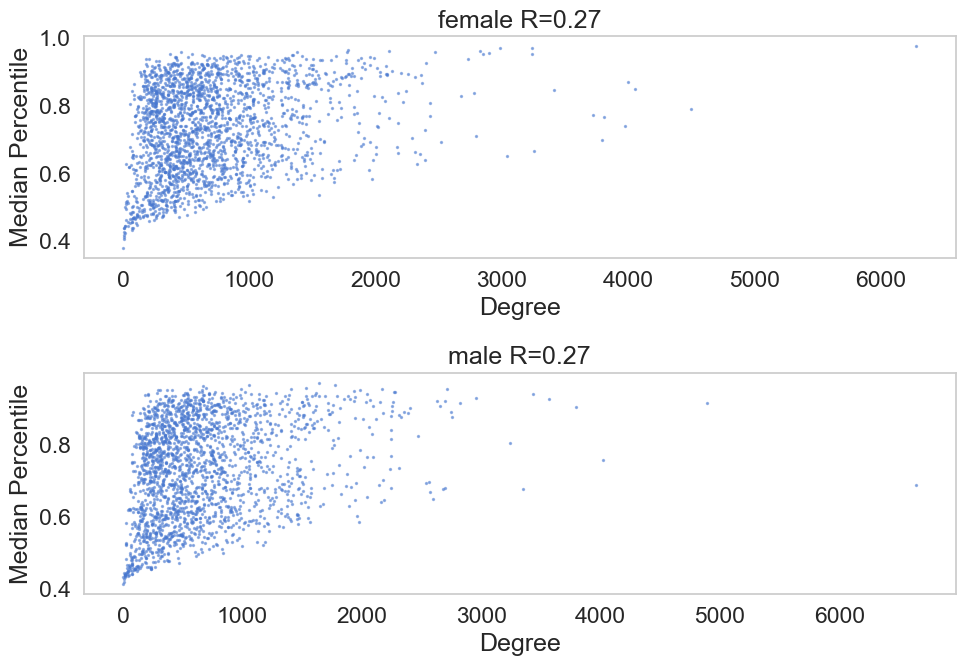

In [40]:
from scipy.stats import pearsonr

fig, ax = plt.subplots(2)
fig.set_size_inches(10,7)

# count number of nan in all_g2g_stats_df['deg]
print('Number of nan in deg', sum(np.isnan(list(all_g2g_stats_df['deg']))))
print('Number of nan in median', sum(np.isnan(list(all_g2g_stats_df['median']))))
print(all_g2g_stats_df.shape)

for i,sex in enumerate(['female','male']):
    sub = all_g2g_stats_df[all_g2g_stats_df['sex'] == sex]
    # what is the correlation between degree and median percentile 
    s, p = pearsonr(sub['deg'],sub['median'])
    ax[i].scatter(sub['deg'],sub['median'],label=sex,s=2,alpha=.5)
    ax[i].set_xlabel('Degree')
    ax[i].set_ylabel('Median Percentile')
    ax[i].set_title(sex + ' R={}'.format(str(round(s,2))))

plt.tight_layout()
plt.show()



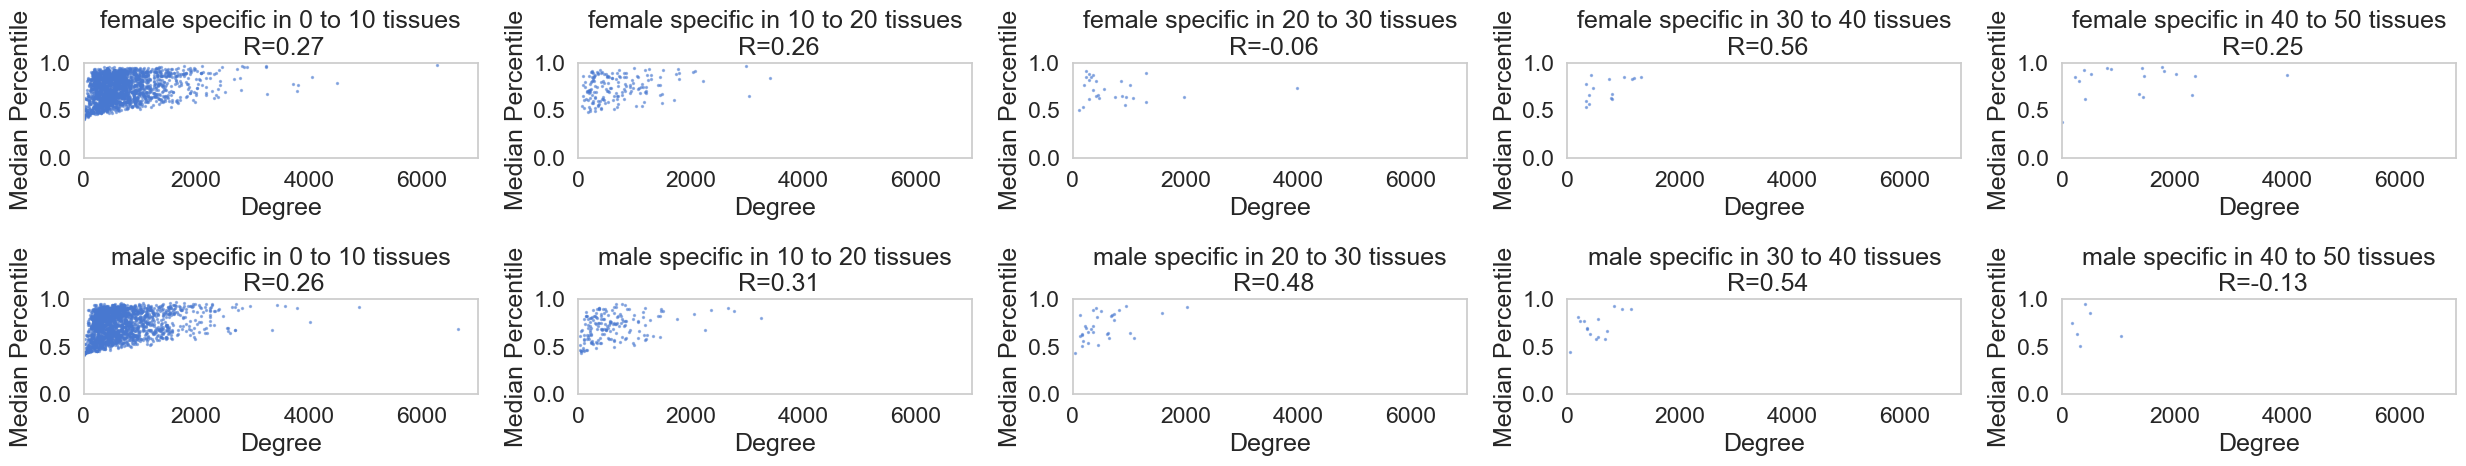

In [41]:
# plot degree and median colored by sex
fig, ax = plt.subplots(2,5)
# set fig size
fig.set_size_inches(25,5)
for j in range(5):
    sub = all_g2g_stats_df[all_g2g_stats_df['tissue_count'] >= j*10]
    sub = sub[sub['tissue_count'] < (j*10)+10]
    for i,sex in enumerate(['female','male']):
        subsub = sub[sub['sex'] == sex]
        s, p = pearsonr(subsub['deg'],subsub['median'])
        ax[i,j].scatter(subsub['deg'],subsub['median'],label=sex,s=2,alpha=.5)
        ax[i,j].set_xlabel('Degree')
        ax[i,j].set_ylabel('Median Percentile')
        ax[i,j].set_title(sex + ' specific in {} to {} tissues\n R={}'.format(str(j*10),str((j*10)+10),str(round(s,2))))
        # set range 0 to 7000 x and 0 to 1 y
        ax[i,j].set_xlim(0,7000)
        ax[i,j].set_ylim(0,1)
plt.tight_layout()
plt.show()

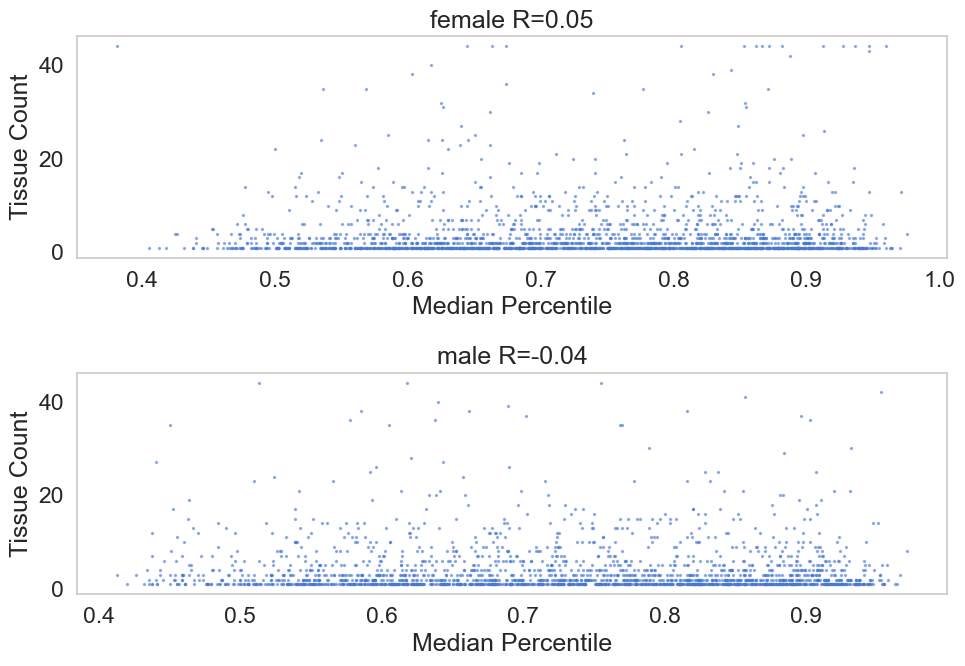

In [42]:
# plot median vs tissue 
fig, ax = plt.subplots(2)
fig.set_size_inches(10,7)

for i,sex in enumerate(['female','male']):
    sub = all_g2g_stats_df[all_g2g_stats_df['sex'] == sex]
    # what is the correlation between degree and median percentile 
    s, p = pearsonr(sub['tissue_count'],sub['median'])
    ax[i].scatter(sub['median'],sub['tissue_count'],label=sex,s=2,alpha=.5)
    ax[i].set_ylabel('Tissue Count')
    ax[i].set_xlabel('Median Percentile')
    ax[i].set_title(sex + ' R={}'.format(str(round(s,2))))

plt.tight_layout()
plt.show()


## Bias again sex-specific genes Premuation Test

It looks like sex-specific genes are less likely inhabibit the top 10% than expected at random.

I want to show this with an emperical p-values

get the median G2G scores for every gene

sample X ( the number of sexually differentially expressed genes) 100 times and compare the number of genes that fall in the top 10%, use this to generate an emperical p-value

19548


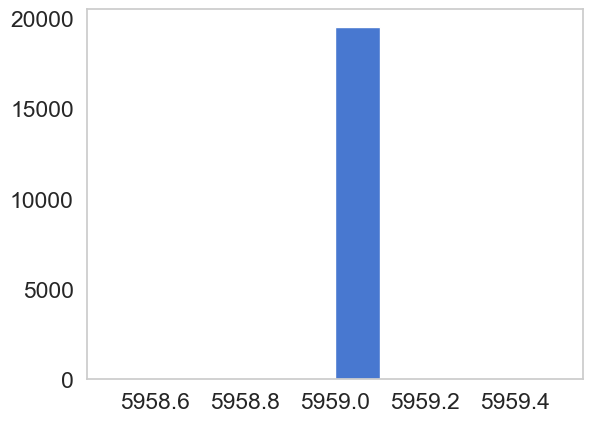

In [43]:

all_g2g_percentiles = None
for f in os.listdir('../G2G_Shards_All/'):
    tmp = pickle.load(open('../G2G_Shards_All/{}'.format(f),'rb'))
    if all_g2g_percentiles is None:
        all_g2g_percentiles = tmp
        continue
    for key in tmp.keys():
        all_g2g_percentiles[key] = all_g2g_percentiles[key] + tmp[key]

print(len(all_g2g_percentiles))

# plot a hist of the lens of each key in male and female
plt.hist([ len(all_g2g_percentiles[k]) for k in all_g2g_percentiles.keys()])
plt.show()


In [44]:
# get the average percentile for each key (gene) in all_g2g_percentiles
all_g2g_stats = []
for key in all_g2g_percentiles.keys():
    all_g2g_stats.append(np.mean(all_g2g_percentiles[key]))

In [54]:
percent_above_female = get_percent_above(all_g2g_stats_df[all_g2g_stats_df['sex'] == 'female'],0.9,1.00)
percent_above_male = get_percent_above(all_g2g_stats_df[all_g2g_stats_df['sex'] == 'male'],0.9,1.00)
percent_above_90_both = get_percent_above(all_g2g_stats_df,0.9,1.00)
print(percent_above_female, percent_above_male, percent_above_90_both)

num_female = sum(all_g2g_stats_df['sex'] == 'female')
num_male = sum(all_g2g_stats_df['sex'] == 'male')

print('Number of sex specific genes:', num_female + num_male)

import random

random.seed(42)

# count the number of times the random sample has more hits above 90% than the real data
reals_win = []
for i in range(5000):
    # choose x items from all_g2g_stats without replacement
    choices = random.sample(all_g2g_stats, num_female + num_male)
    # get the percent above 0.9
    percent_wins = len([1 for x in choices if x >= 0.9])/len(choices)
    reals_win.append(percent_wins < percent_above_90_both)

print('Emperical p-value', 1.00 - (sum(reals_win)/len(reals_win)))


    

0.04661791590493602 0.05012048192771084 0.0483227773868168
Number of sex specific genes: 4263
Emperical p-value 0.0
